In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [3]:
# Load your dataset
# Replace this with your data loading code
data = pd.read_csv('../south dakota weather data/South_Dakota_climate_Data_1.csv')

In [4]:
# Choose the target columns (e.g., 'Avg. Temp', 'Min. Temp', 'Max. Temp', 'Precipitation', 'Heating Degrees Days', 'Cooling Degrees Days')
data = data[['Avg. Temp', 'Min. Temp', 'Max. Temp', 'Precipitation', 'Heating Degrees Days']].values
data = data.astype('float32') #convert values to float

In [5]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data = scaler.fit_transform(data)

In [6]:
data

array([[0.13672316, 0.13586292, 0.13836476, 0.0945347 , 0.8876124 ],
       [0.19548023, 0.20440637, 0.18763101, 0.10044312, 0.7327672 ],
       [0.3864407 , 0.376989  , 0.39308175, 0.15066469, 0.55444556],
       ...,
       [0.8587571 , 0.89351285, 0.8291404 , 0.37666175, 0.01798202],
       [0.8677966 , 0.90820074, 0.8333333 , 0.50812405, 0.00999001],
       [0.79322034, 0.8188495 , 0.7704402 , 0.33234861, 0.04745255]],
      dtype=float32)

In [7]:
# Define the train-test split ratio (80:20)
train_size = int(len(data) * 0.90)
test_size = len(data) - train_size
train, test = data[0:train_size, :], data[train_size:len(data), :]
print(len(train))
print(len(test))

1390
155


In [8]:
def to_sequences(dataset, seq_size=6, step_size=1, target_size=6):
    x = []
    y = []

    for i in range(0, len(dataset)-seq_size-target_size + 1, step_size):
        #print(i)
        window = dataset[i:(i+seq_size)]
        x.append(window)
        target = dataset[i + seq_size: i + seq_size + target_size]
        y.append(target)
    
    return np.array(x),np.array(y)

In [9]:
seq_size = 6  # Number of time steps to look back
step_size=1   # Number of steps that is going to increase for the next sequence
target_size=6 # Number of values that is going to generate as the output

In [10]:
trainX, trainY = to_sequences(train, seq_size, step_size, target_size)
testX, testY = to_sequences(test, seq_size, step_size, target_size)

In [11]:
trainX.shape

(1379, 6, 5)

In [12]:
trainY.shape

(1379, 6, 5)

In [13]:
testX.shape

(144, 6, 5)

In [14]:
testY.shape

(144, 6, 5)

In [15]:
from tensorflow.keras.layers import TimeDistributed

# Build the model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_size, 5), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(5))  # Adjust the output shape to (5)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [16]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 6, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 6, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 6, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 6, 50)             0         
                                                                 
 dense (Dense)               (None, 6, 5)              2

In [17]:
# Train the model
history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), callbacks=[early_stopping])

Epoch 1/100
28/28 [==============================] - 18s 208ms/step - loss: 0.1824 - mean_absolute_error: 0.3467 - val_loss: 0.1222 - val_mean_absolute_error: 0.2784
Epoch 2/100
28/28 [==============================] - 1s 36ms/step - loss: 0.1094 - mean_absolute_error: 0.2635 - val_loss: 0.0929 - val_mean_absolute_error: 0.2451
Epoch 3/100
28/28 [==============================] - 1s 41ms/step - loss: 0.0833 - mean_absolute_error: 0.2329 - val_loss: 0.0672 - val_mean_absolute_error: 0.2134
Epoch 4/100
28/28 [==============================] - 1s 35ms/step - loss: 0.0610 - mean_absolute_error: 0.2001 - val_loss: 0.0442 - val_mean_absolute_error: 0.1684
Epoch 5/100
28/28 [==============================] - 1s 34ms/step - loss: 0.0364 - mean_absolute_error: 0.1471 - val_loss: 0.0235 - val_mean_absolute_error: 0.1124
Epoch 6/100
28/28 [==============================] - 1s 49ms/step - loss: 0.0251 - mean_absolute_error: 0.1208 - val_loss: 0.0173 - val_mean_absolute_error: 0.0982
Epoch 7/100
28

Epoch 51/100
28/28 [==============================] - 1s 44ms/step - loss: 0.0091 - mean_absolute_error: 0.0719 - val_loss: 0.0080 - val_mean_absolute_error: 0.0660
Epoch 52/100
28/28 [==============================] - 1s 39ms/step - loss: 0.0090 - mean_absolute_error: 0.0716 - val_loss: 0.0081 - val_mean_absolute_error: 0.0664
Epoch 53/100
28/28 [==============================] - 1s 30ms/step - loss: 0.0090 - mean_absolute_error: 0.0711 - val_loss: 0.0083 - val_mean_absolute_error: 0.0679
Epoch 54/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0090 - mean_absolute_error: 0.0713 - val_loss: 0.0080 - val_mean_absolute_error: 0.0663
Epoch 55/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0089 - mean_absolute_error: 0.0708 - val_loss: 0.0079 - val_mean_absolute_error: 0.0655
Epoch 56/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0089 - mean_absolute_error: 0.0708 - val_loss: 0.0082 - val_mean_absolute_error: 0.0678
Epoch 57/1

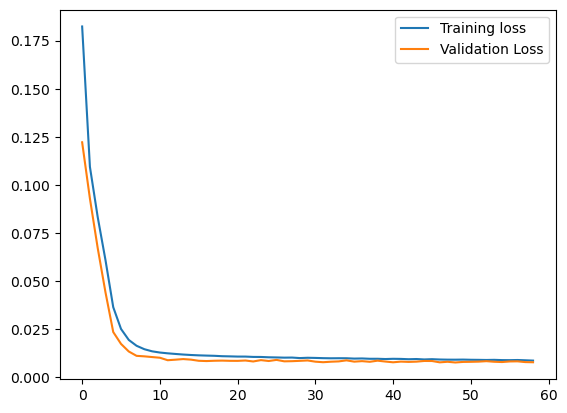

In [18]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

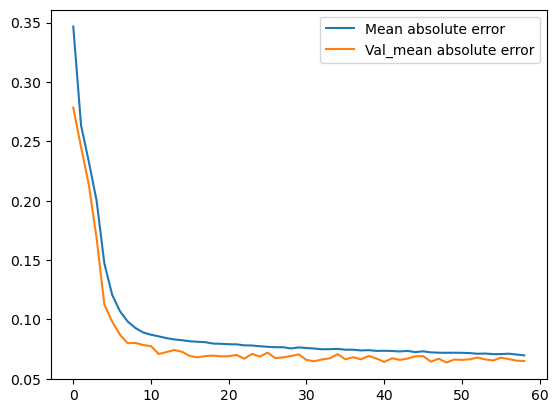

In [19]:
plt.plot(history.history['mean_absolute_error'],label='Mean absolute error')
plt.plot(history.history['val_mean_absolute_error'],label='Val_mean absolute error')
plt.legend()

In [20]:
trainX.shape

(1379, 6, 5)

In [21]:
# Make predictions on the test data
testPredict = model.predict(testX)

# Inverse transform the predictions to the original scale
#testPredict = scaler.inverse_transform(testPredict)

# Optionally, inverse transform the testY (true values) if it was scaled
#testY = scaler.inverse_transform(testY)

# Now, you can compare the testY (true values) with the predicted values
# For example, to check the predictions for the first sequence:
print("True Values (TestY):")
print(testY[0])  # This contains the true values for the first sequence

print("Predicted Values:")
print(testPredict[0])  # This contains the predicted values for the first sequence

5/5 [==============================] - 2s 9ms/step
True Values (TestY):
[[0.6576271  0.7062424  0.615304   0.66322005 0.18181817]
 [0.7898305  0.8384333  0.7463313  0.6661743  0.05094905]
 [0.9163842  0.9742962  0.86582804 0.46381095 0.0034965 ]
 [0.8677966  0.9057528  0.8343815  0.34121123 0.01048951]
 [0.73559326 0.7405141  0.730608   0.0915805  0.09840159]
 [0.6384181  0.65483475 0.6236897  0.16248153 0.2097902 ]]
Predicted Values:
[[0.7372663  0.76061046 0.7150536  0.34817943 0.12023595]
 [0.81721056 0.84551454 0.791895   0.39169428 0.04447037]
 [0.86414707 0.8939225  0.8396103  0.37582797 0.01823679]
 [0.82876503 0.85465205 0.8076654  0.31322265 0.037754  ]
 [0.75182784 0.77258223 0.73328024 0.25346804 0.09725517]
 [0.5987775  0.6151318  0.582216   0.17540541 0.25151968]]


In [22]:
# After training, you can make predictions on the test data
testPredict = model.predict(testX)

5/5 [==============================] - 0s 15ms/step


In [23]:
# Inverse transform the predictions to the original scale if you had previously scaled your data using a MinMaxScaler
#testPredict = scaler.inverse_transform(testPredict)

In [24]:
trainPredict = model.predict(trainX)

# Inverse transform the predictions to the original scale
#trainPredict = scaler.inverse_transform(trainPredict)

# Optionally, inverse transform the trainY (true values) if it was scaled
#trainY = scaler.inverse_transform(trainY)

# Now, you can compare the trainY (true values) with the predicted values
# For example, to check the predictions for the first sequence:
print("True Values (TrainY):")
print(trainY[0])  # This contains the true values for the first sequence

print("Predicted Values:")
print(trainPredict[0])  # This contains the predicted values for the first sequence


44/44 [==============================] - 0s 7ms/step
True Values (TrainY):
[[0.84745765 0.8531212  0.8396226  0.19940916 0.02347652]
 [0.83841807 0.83353734 0.8406709  0.19054651 0.02197802]
 [0.75141245 0.73317015 0.76624733 0.15066469 0.08041958]
 [0.54915255 0.5287638  0.567086   0.02215657 0.33016983]
 [0.36497176 0.38555694 0.34591192 0.16838995 0.5514485 ]
 [0.29943502 0.3108935  0.28825995 0.03988183 0.6768232 ]]
Predicted Values:
[[0.85985374 0.89162666 0.8361906  0.42502043 0.00924386]
 [0.85205746 0.8832615  0.8290456  0.36532927 0.01541084]
 [0.7851547  0.80925137 0.7671544  0.27667615 0.07559434]
 [0.54126906 0.5567646  0.5267497  0.13897072 0.32501048]
 [0.37645948 0.3917837  0.3607859  0.07859472 0.53543526]
 [0.2843163  0.3013994  0.26820806 0.04966003 0.67344624]]


In [25]:
trainPredict = model.predict(trainX)

44/44 [==============================] - 0s 6ms/step


In [26]:
# Inverse transform the predictions to the original scale if you had previously scaled your data using a MinMaxScaler
#testPredict = scaler.inverse_transform(testPredict)

In [27]:
# You can also optionally inverse transform the testY (true values) if it was scaled
# testY = scaler.inverse_transform(testY)

# Calculate RMSE for the test data
#testScore = math.sqrt(mean_squared_error(testY, testPredict))
#print('Test Score: %.2f RMSE' % (testScore))

# Calculate RMSE for the test data
testScore = math.sqrt(mean_squared_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5)))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.09 RMSE


In [28]:
# You can also optionally inverse transform the testY (true values) if it was scaled
# testY = scaler.inverse_transform(testY)

# Calculate RMSE for the test data
#trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
#print('Train Score: %.2f RMSE' % (trainScore))

# Calculate RMSE for the train data
trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1, 5), trainPredict.reshape(-1, 5)))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.08 RMSE


In [29]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error
#mae = mean_absolute_error(testY, testPredict)
#print("Mean Absolute Error (MAE):", mae)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.06497365


In [30]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the Mean Absolute Percentage Error
mae = mean_absolute_percentage_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5))
print("Mean Absolute Percentage Error (MAPE):", mae)

Mean Absolute Percentage Error (MAPE): 0.4300807


In [31]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the Mean Absolute Percentage Error

trainScore = mean_absolute_percentage_error(trainY.reshape(-1, 5), trainPredict.reshape(-1, 5))
print("Mean Absolute Percentage Error (MAPE):", mae)

Mean Absolute Percentage Error (MAPE): 0.4300807
